Aprendizaje Automático - Práctica 2
Autores: RICARDO ANTONIO PAZOS VALERO - 100472303 / VICENTE ANTONIO BARBATO - 10043114

# 1. K-Means
---
Programamos el algoritmo K-Means y comparamos nuestra implementación con la implementación de sklearn

In [25]:
# Importamos
import numpy as np

# Desarrollamos nuestro propio K-Means
def distance(p1, p2):
    """Función auxiliar que calcula la distancia euclidiana entre dos puntos"""
    return np.sqrt(np.sum((p1-p2)**2))

def myKMeans(X, clusters, k):
    """Nuestra función KMeans"""
    # Asignamos clusters
    for idx in range(X.shape[0]):
        dist = []
         
        current_x = X[idx]
         
        for i in range(k):
            dis = distance(current_x, clusters[i]['center'])
            dist.append(dis)
        curr_cluster = np.argmin(dist)
        clusters[curr_cluster]['points'].append(current_x)

    # Actualizamos clusters
    for i in range(k):
        points = np.array(clusters[i]['points'])
        if points.shape[0] > 0:
            new_center = points.mean(axis =0)
            clusters[i]['center'] = new_center
             
            clusters[i]['points'] = []
    
    return clusters

def myKMeansPred(X, clusters, k):
    """Nuestra función para hacer Predict"""
    # Predecimos los clusters para los datapoints
    pred = []
    for i in range(X.shape[0]):
        dist = []
        for j in range(k):
            dist.append(distance(X[i],clusters[j]['center']))
        pred.append(np.argmin(dist))
    
    return pred

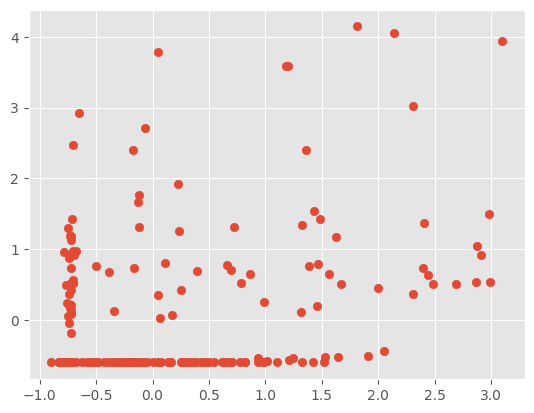

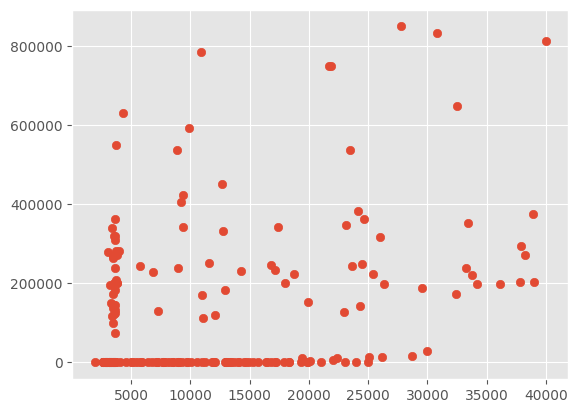

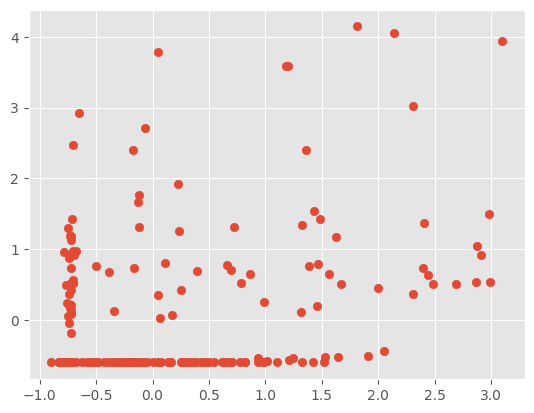

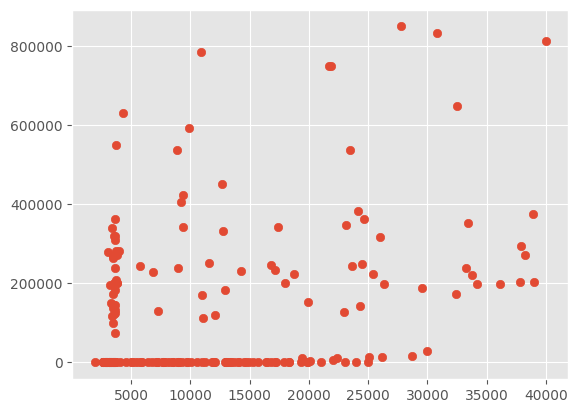

In [26]:
# Importamos
# === Tratamiento de datos =====================================================
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

# === Gráficos =================================================================
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# === Preprocesado y modelado ==================================================
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import silhouette_score, silhouette_samples

# === Configuración warnings ===================================================
import warnings
warnings.filterwarnings('ignore')

# Cargamos los datos
data = pd.read_csv('data/stars_data.csv')

# Definimos nuestro conjunto de datos
X = data.values

# Copiamos el conjunto de datos original para preservarlo
X_onehot = X.copy()
X_ordinal = X.copy()

# === Codificamos valores de tipo str (color y clase espectral) ============================
# One-Hot Encoder
encoder_onehot = OneHotEncoder(sparse_output=False)
X_onehot_encoded = encoder_onehot.fit_transform(X_onehot[:, -2:])

# Eliminamos filas tipo str - One Hot
X_onehot = X_onehot[:, :-2]

# Concatenamos las nuevas filas codificadas - One Hot
X_onehot = np.concatenate((X_onehot, X_onehot_encoded), axis=1)

# Ordinal Encoder
encoder_ordinal = OrdinalEncoder()
X_ordinal_encoded = encoder_ordinal.fit_transform(X_onehot[:, -2:])

# Eliminamos filas tipo str - Ordinal
X_ordinal = X_ordinal[:, :-2]

# Concatenamos las nuevas filas codificadas - Ordinal
X_ordinal = np.concatenate((X_ordinal, X_ordinal_encoded), axis=1)

# Escalamos los datos
X_onehot_scaled = scale(X_onehot)
X_ordinal_scaled = scale(X_ordinal)

# === Representamos data ==========================================================
# Figura para onehot data
fig_onehot_scaled = plt.figure(0)
plt.grid(True)
plt.scatter(X_onehot_scaled[:,0],X_onehot_scaled[:,1])
plt.show()

fig_onehot = plt.figure(0)
plt.grid(True)
plt.scatter(X_onehot[:,0],X_onehot[:,1])
plt.show()

# Figura para ordinal data
fig_ordinal_scaled = plt.figure(0)
plt.grid(True)
plt.scatter(X_ordinal_scaled[:,0],X_ordinal_scaled[:,1])
plt.show()

fig_ordinal = plt.figure(0)
plt.grid(True)
plt.scatter(X_ordinal[:,0],X_ordinal[:,1])
plt.show()

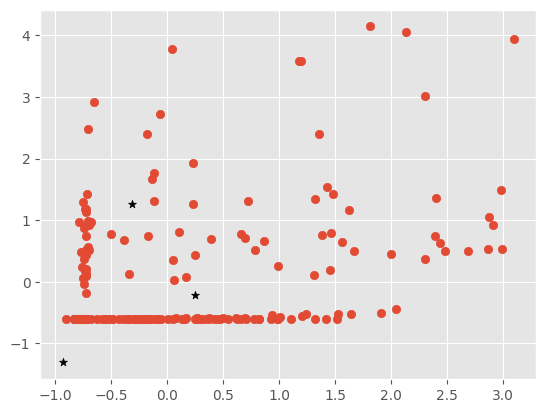

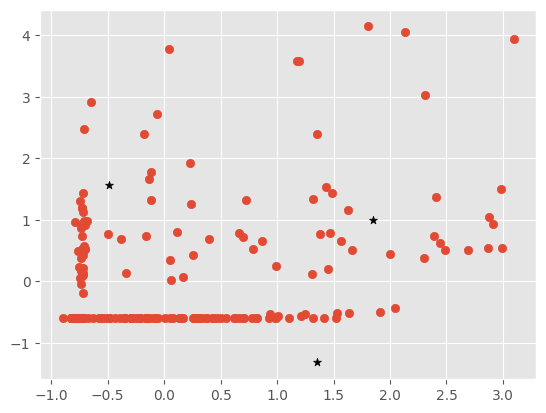

In [27]:
# Inicializamos los centroides para los clusters
k = 3
clusters_onehot = {}
clusters_ordinal = {}
np.random.seed(100572303)

# Clusters con onehot data
for idx in range(k):
    center = 2*(2*np.random.random((X_onehot_scaled.shape[1],))-1)
    points = []
    cluster = {
        'center' : center,
        'points' : []
    }
     
    clusters_onehot[idx] = cluster

# Clusters con ordinal data
for idx in range(k):
    center = 2*(2*np.random.random((X_ordinal_scaled.shape[1],))-1)
    points = []
    cluster = {
        'center' : center,
        'points' : []
    }
     
    clusters_ordinal[idx] = cluster

# Representamos la figura para onehot
plt.scatter(X_onehot_scaled[:,0],X_onehot_scaled[:,1])
plt.grid(True)
for i in clusters_onehot:
    center = clusters_onehot[i]['center']
    plt.scatter(center[0],center[1],marker = '*',c = 'black')
plt.show()

# Representamos la figura para ordinal
plt.scatter(X_ordinal_scaled[:,0],X_ordinal_scaled[:,1])
plt.grid(True)
for i in clusters_ordinal:
    center = clusters_ordinal[i]['center']
    plt.scatter(center[0],center[1],marker = '*',c = 'black')
plt.show()

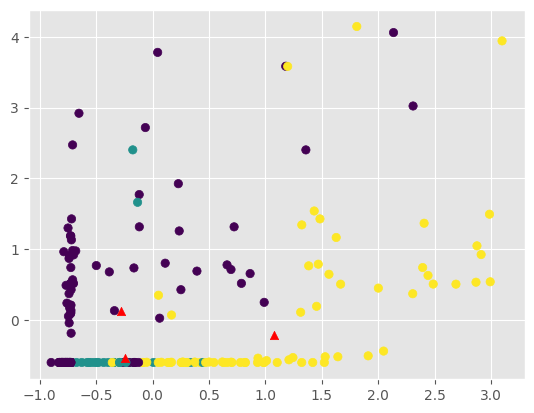

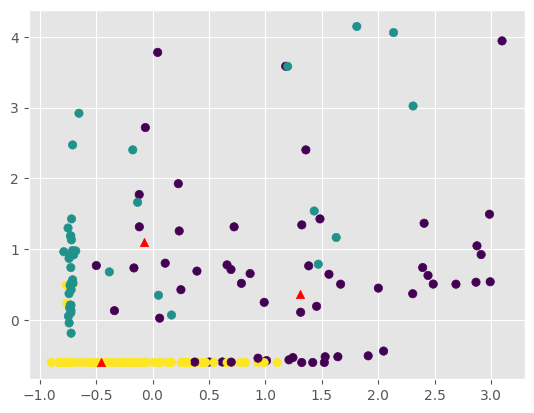

In [28]:
# === myKMeans ==================================================================
# Ejecutamos nuestro KMeans sobre data onehot
clusters_onehot = myKMeans(X_onehot_scaled, clusters_onehot, k)
pred = myKMeansPred(X_onehot_scaled, clusters_onehot, k)

# Representamos la figura
plt.scatter(X_onehot_scaled[:,0],X_onehot_scaled[:,1],c = pred)
for i in clusters_onehot:
    center = clusters_onehot[i]['center']
    plt.scatter(center[0],center[1],marker = '^',c = 'red')
plt.show()

# Ejecutamos nuestro KMeans sobre data ordinal
clusters_ordinal = myKMeans(X_ordinal_scaled, clusters_ordinal, k)
pred = myKMeansPred(X_ordinal_scaled, clusters_ordinal, k)

# Representamos la figura
plt.scatter(X_ordinal_scaled[:,0],X_ordinal_scaled[:,1],c = pred)
for i in clusters_ordinal:
    center = clusters_ordinal[i]['center']
    plt.scatter(center[0],center[1],marker = '^',c = 'red')
plt.show()


In [29]:
# === KMeans =====================================================================
# Definimos el número de clusters
n_clusters = 4

# KMeans de sklearn con one hot encoded data
kmeans_onehot = KMeans(n_clusters=n_clusters, random_state=100472303)
kmeans_onehot.fit(X_onehot_scaled)

# KMeans de sklearn con ordinal encoded data
kmeans_ordinal = KMeans(n_clusters=n_clusters, random_state=100472303)
kmeans_ordinal.fit(X_ordinal_scaled)

KMeans(n_clusters=4, random_state=100472303)